# Error Correction

Here we present two application examples of quantum error correcting codes: the Shor Code for correction on a noisy communication channel and the Steane code for a fault-tolerant 2-qubit Grover's algorithm

Import the required packages and intiailize the least busy backend

In [1]:
import numpy as np
from qiskit import IBMQ, Aer, assemble, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

from qiskit.visualization import plot_histogram

provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))

# Transmission through a noisy channel

Simulating transmission through a noisy channel without encoding

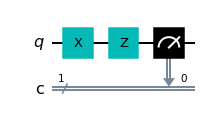

In [8]:
q = QuantumRegister(1, 'q')
c = ClassicalRegister(1, 'c')
qc = QuantumCircuit(q, c)


qc.x(0)
qc.z(0)
qc.measure(0, c)
qc.draw(output="mpl")

Running simulation for the uncorrected circuit

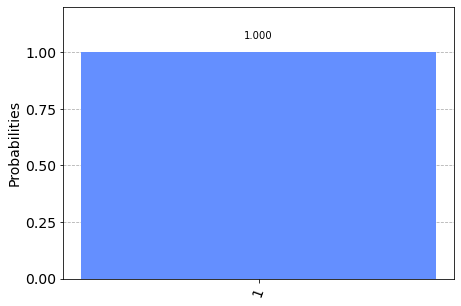

In [9]:
aer_sim = Aer.get_backend('aer_simulator')
result = aer_sim.run(assemble(qc)).result()
counts = result.get_counts()
plot_histogram(counts)

We get corrupted information on the other end of the channel ('1' instead of '0'). Let's run on quantum hardware:

Job Status: job has successfully run


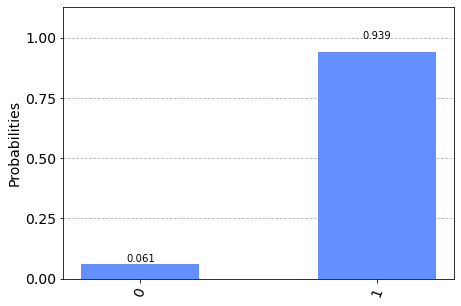

In [10]:
# Run on the least busy backend
transpiled = transpile(qc, device, optimization_level=3)
job = device.run(transpiled)
job_monitor(job, interval=2)

results = job.result()
answer = results.get_counts(qc)
plot_histogram(answer)

## The Shor Code

In [15]:
class ShorCode:
    def __init__(self, n = 1):
        # number of logical qubits
        self.n = 1
        self.qc = QuantumCircuit(n)

    # encoder to prepare logical qubits on 9 physical qubits each
    def encode(self):
        n = self.n

        # encoder circuit for every logical qubit
        # store number of main (non-auxilary) qubits for the decoder
        encoder = QuantumCircuit(n*9)
        for i in range(n):
            f = 9*i
            encoder.cx(f,f+3)
            encoder.cx(f,f+6)

            encoder.h(f)
            encoder.h(f+3)
            encoder.h(f+6)

            encoder.cx(f,f+1)
            encoder.cx(f+3,f+4)
            encoder.cx(f+6,f+7)

            encoder.cx(f,f+2)
            encoder.cx(f+3,f+5)
            encoder.cx(f+6,f+8)

        encoder.barrier()
        self.qc = encoder
        return self.qc


    # decoder to correct and decode data
    def decode(self):
        circuit = self.qc
        n = self.n

        decoder = QuantumCircuit(n*9)
        for i in range(n):
            f = 9*i
            decoder.cx(f,f + 1)
            decoder.cx(f + 3, f + 4)    
            decoder.cx(f + 6,f + 7)

            decoder.cx(f,f + 2)
            decoder.cx(f + 3,f + 5)
            decoder.cx(f + 6,f + 8)

            decoder.ccx(f + 1,f + 2,f + 0)
            decoder.ccx(f + 4,f + 5,f + 3)
            decoder.ccx(f + 8,f + 7,f + 6)

            decoder.h(f)
            decoder.h(f + 3)
            decoder.h(f + 6)

            decoder.cx(f + 0, f+ 3)
            decoder.cx(f + 0,f + 6)
            decoder.ccx(f + 6, f + 3, f)
        combined = circuit.compose(decoder)
        self.qc = combined
        return self.qc 

    # add random errors for a physical qubit for every logical qubit
    def add_errors(self):
        circuit = self.qc
        n = self.n
        for i in range(n):
            physical_qubit = np.random.randint(9*i,9 * (i + 1))
            circuit.x(physical_qubit)
            circuit.z(physical_qubit)
        circuit.barrier()
        return self.qc
        

    

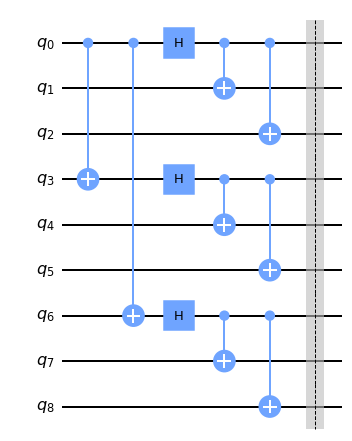

In [20]:
# The encoder
shor_code = ShorCode(1)
shor_code.encode()
shor_code.qc.draw(output="mpl")

Transmission through a noisy channel

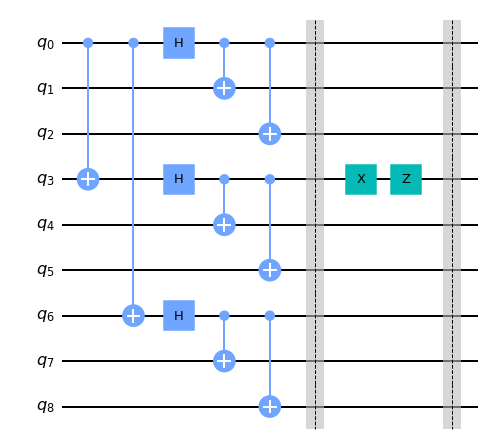

In [21]:
shor_code.add_errors()
shor_code.qc.draw(output="mpl")

Decode

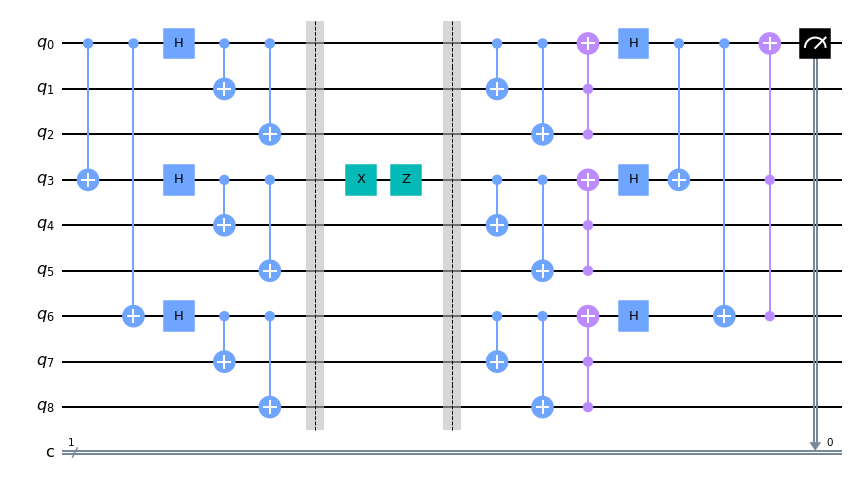

In [22]:
corrected_qc = shor_code.decode()
c = ClassicalRegister(1, 'c')
corrected_qc.add_register(c)
result = corrected_qc.measure(0, c)
corrected_qc.draw(output="mpl")

Running simulation for the corrected circuit

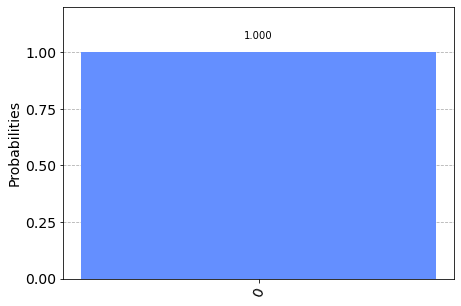

In [23]:
result = aer_sim.run(assemble(corrected_qc)).result()
counts = result.get_counts()
plot_histogram(counts)

As we see we get '0', which means that our Shor error correcting circuit works as expected!

# Fault tolerant Grover Circuit

A simple 2-qubit Grover circuit for searching the |11> state

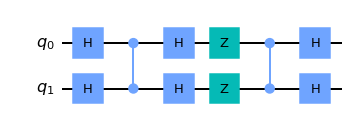

In [91]:
grover_circuit = QuantumCircuit(2)

grover_circuit.h(0)
grover_circuit.h(1)
grover_circuit.cz(0,1) 
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])

grover_circuit.draw(output="mpl")


Running the circuit without errors to get the expected result.

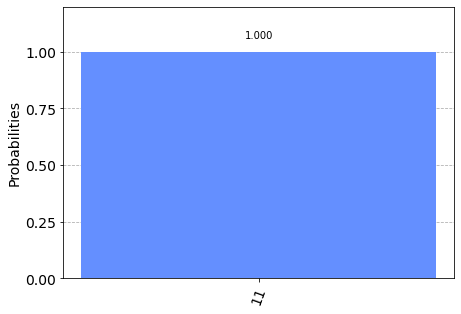

In [92]:
grover_circuit.measure_all()
result = aer_sim.run(assemble(grover_circuit)).result()
counts = result.get_counts()
plot_histogram(counts)

# The Steane Code

A utility function for measuring logical qubits in the Z basis

In [50]:
# Measure the target in the Z basis using ancilla
def logical_z_measure(qc, ancilla, target, measurement):
    # initialize ancilla to |0>
    qc.initialize('0',ancilla)

    # Hadamard + ctrl-Z
    qc.h(ancilla)
    qc.cz(ancilla, target)
    qc.h(ancilla)

    # measure
    qc.measure(ancilla, measurement)

Steane Code

In [51]:
class SteaneCode:
    # initialize a circuit for Steane code on logical_qubits
    def __init__(self, logical_qubits):
        self.n = len(logical_qubits)
        self.encoded_qubits = []
        self.additional_qubits = {}


        self.additional_qubits['x_anc'] = QuantumRegister(3, 'x_anc')
        self.additional_qubits['z_anc'] = QuantumRegister(3, 'z_anc')
        self.additional_qubits['x_synd'] = ClassicalRegister(3, 'x_synd')
        self.additional_qubits['z_synd'] = ClassicalRegister(3, 'z_synd')

        for i in range(self.n ):
            self.encoded_qubits.append({})
            self.encoded_qubits[i]['logical'] = logical_qubits[i]
            self.encoded_qubits[i]['meas_anc'] = QuantumRegister(1, 'meas_anc' + str(i))
            self.encoded_qubits[i]['meas'] = ClassicalRegister(1, 'meas' + str(i))

        self.qc = QuantumCircuit()
    
    # prepare encoded qubits of the circuit
    def prepare(self):
        qc = self.qc
        x_anc = self.additional_qubits['x_anc']
        z_anc = self.additional_qubits['z_anc']
        x_synd = self.additional_qubits['x_synd']
        z_synd = self.additional_qubits['z_synd']

        qc.add_register(x_anc, z_anc, x_synd, z_synd)

        for i in range(self.n):
            logical = self.encoded_qubits[i]['logical']
            meas_anc = self.encoded_qubits[i]['meas_anc']
            meas = self.encoded_qubits[i]['meas']

            qc.add_register(logical,  meas_anc, meas)
        self.correct_all()
        return self.qc

            
    # correct the specified logical qubits
    def correct(self, *indices):
        qc = self.qc
        
        x_anc = self.additional_qubits['x_anc']
        z_anc = self.additional_qubits['z_anc']
        x_synd = self.additional_qubits['x_synd']
        z_synd = self.additional_qubits['z_synd']

        for i in indices:
            logical = self.encoded_qubits[i]['logical']

            # initialize ancillary qubits to |0>
            qc.initialize('000', x_anc)
            qc.initialize('000', z_anc)

            # Hadamard gates on ancilla qubits
            qc.h(x_anc)
            qc.h(z_anc)
        
            # measure stabilizer generators
            qc.cx(z_anc[2], [logical[i-1] for i in [4,5,6,7]])
            qc.cx(z_anc[1], [logical[i-1] for i in [2,3,6,7]])
            qc.cx(z_anc[0], [logical[i-1] for i in [1,3,5,7]])
            
            qc.cz(x_anc[2], [logical[i-1] for i in [4,5,6,7]])
            qc.cz(x_anc[1], [logical[i-1] for i in [2,3,6,7]])
            qc.cz(x_anc[0], [logical[i-1] for i in [1,3,5,7]])


            # Hadamard gates on ancilla qubits
            qc.h(x_anc)
            qc.h(z_anc)


            # measure ancilla qubits to get syndroms
            qc.measure(x_anc, x_synd)
            qc.measure(z_anc, z_synd)


            # correct if needed
            for i in range(1,8):
                qc.x(logical[i-1]).c_if(x_synd,i)
            for i in range(1,8):
                qc.z(logical[i-1]).c_if(z_synd,i)
        
        return self.qc


    # measure the specified logical qubits
    def measure(self, *indices):
        qc = self.qc
        for i in indices:
            logical = self.encoded_qubits[i]['logical']
            meas_anc = self.encoded_qubits[i]['meas_anc']
            meas = self.encoded_qubits[i]['meas']
            logical_z_measure(qc, meas_anc, logical, meas)
        
        return self.qc

    
    # add errors to random physical qubits of specified logical qubits
    def add_errors(self, *indices):
        qc = self.qc
        for i in indices:
            logical = self.encoded_qubits[i]['logical']
            qc.x(logical[np.random.randint(0,7)])
            qc.z(logical[np.random.randint(0,7)])
        
        return self.qc

    # correct all qubits
    def correct_all(self):
        self.correct(*range(self.n))
        return self.qc
        
    # measure all qubits
    def measure_all(self):
        self.measure(*range(self.n))
        return self.qc

    # add errors to random physical qubits of all logical qubits
    def add_errors_all(self):
        self.add_errors(*range(self.n))
        return self.qc

In [52]:
sim = Aer.get_backend('aer_simulator_extended_stabilizer')

# return encoded grover circuit with errors and optional error correction
def error_grover(correct = False):
    logical0 = QuantumRegister(7, 'logical_qubit0')
    logical1 = QuantumRegister(7, 'logical_qubit1')

    # initialize steane code and prepare logical encoded states
    stean_code = SteaneCode([logical0, logical1])
    stean_code.prepare()

    ### Grover
    
    # uniform superposition
    stean_code.qc.h(logical0)
    stean_code.qc.h(logical1)

    # add and correct errors, assuming that correction is performed periodically
    stean_code.add_errors_all()
    if correct:
        stean_code.correct_all()

    # oracle
    stean_code.qc.cz(logical0, logical1)
    
    # diffuser
    stean_code.qc.h(logical0)
    stean_code.qc.h(logical1)
    stean_code.qc.z(logical0)
    stean_code.qc.z(logical1)
    stean_code.qc.cz(logical0, logical1)
    stean_code.qc.h(logical0)
    stean_code.qc.h(logical1)
    

    stean_code.measure_all()
    return stean_code.qc

Simulating for Grover with errors, we get a wrong result: the state |00> instead of the expected |11>

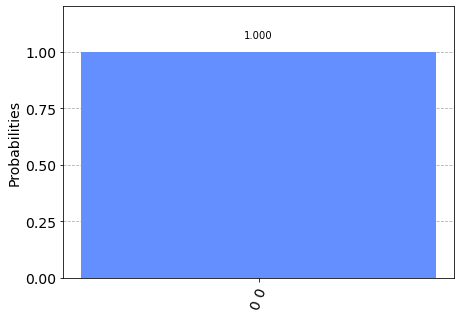

In [53]:
total_counts = {}
# run 100 circuits with different error configurations for each physical qubits
for i in range(100):
    counts = execute(error_grover(), sim).result().get_counts()

    # get measurement outcomes
    for key in counts.keys():
        trimkey = key[0:3][::-1] 
        if trimkey in total_counts.keys():
            total_counts[trimkey] += counts[key]
        else:
            total_counts[trimkey] = counts[key]

plot_histogram(total_counts)

Run the same simulation, with enabled error correction to get the correct result |11>

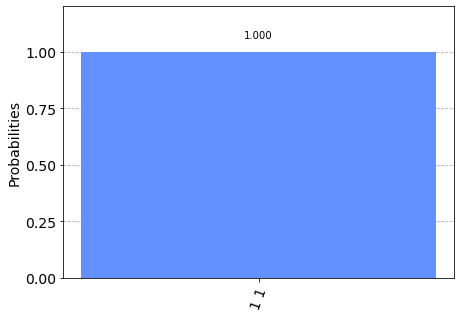

In [54]:
total_counts = {}
# run 100 circuits with different error configurations for each physical qubits
for i in range(100):
    counts = execute(error_grover(True), sim).result().get_counts()

    # get measurement outcomes
    for key in counts.keys():
        trimkey = key[0:3][::-1] 
        if trimkey in total_counts.keys():
            total_counts[trimkey] += counts[key]
        else:
            total_counts[trimkey] = counts[key]

plot_histogram(total_counts)

We get '11', which means that our Steane error corrected Grover circuit works as expected! The circuit looks as follows: 

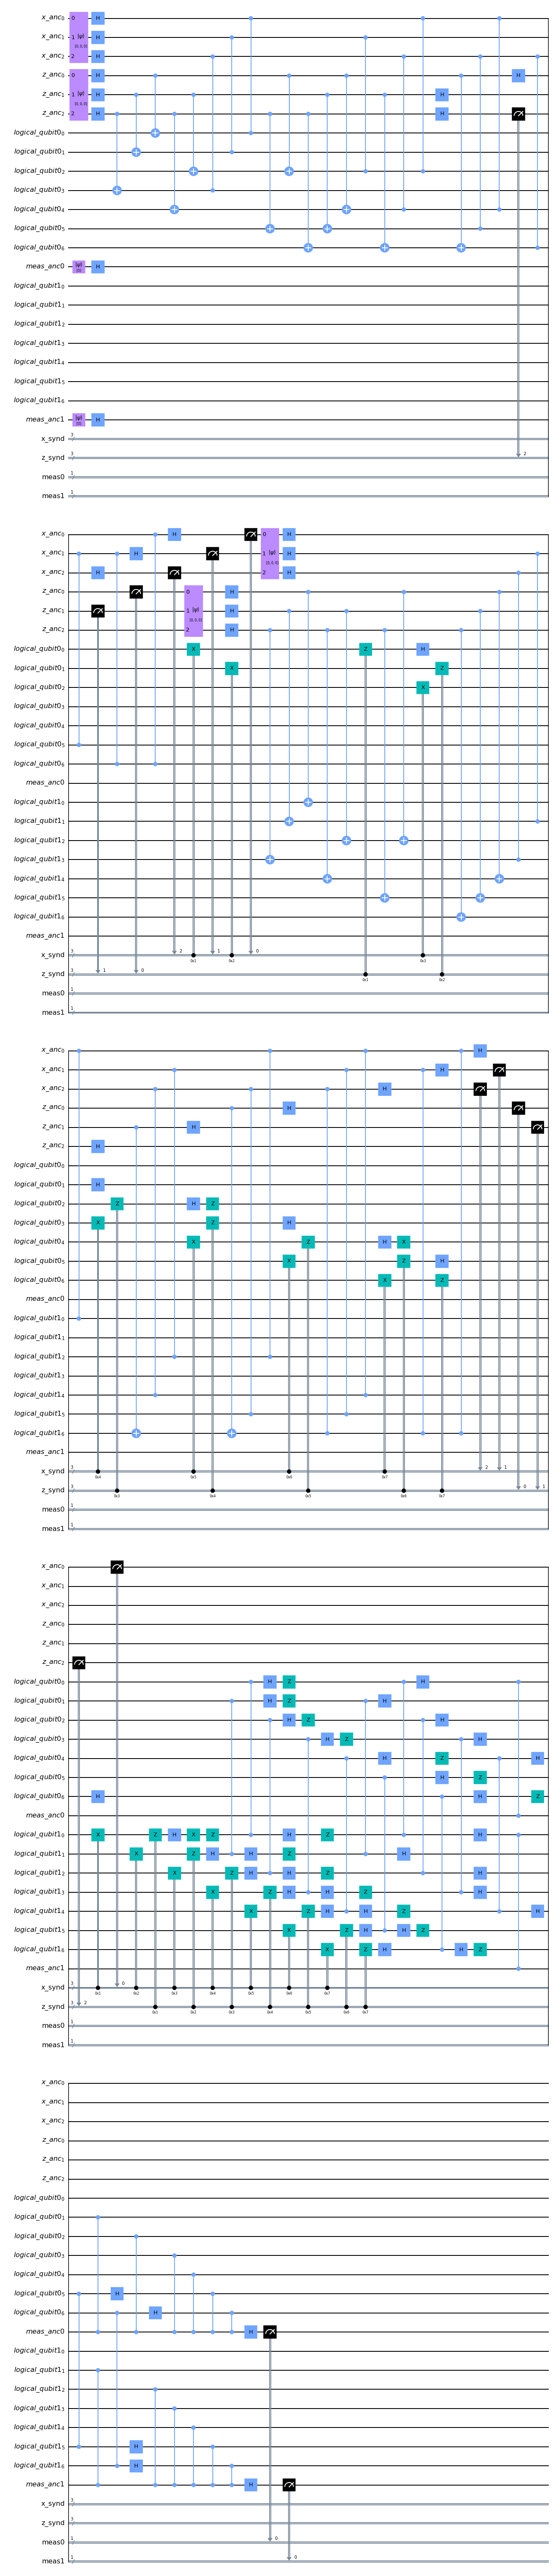

In [55]:
qc.draw(output="mpl")

The circuit width (number of qubits) and size (number of gates) make it impossible for this simulation to be run on an actual IBM cloud quantum computer with the free quota.

In [56]:
qc.size()

212

In [57]:
qc.width()

30